In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters

from svetlanna import simulation_parameters as sp
from svetlanna import wavefront as w

Let us find the numerical and analytical solution of the problem of free propagation of a Gaussian beam at distance $z_{total}$:

In [11]:
lx = 12
ly = 12

z = 150
z_total = 300

w0 = 2
lam = 1064*1e-6
# lam = 660* 1e-6
length = 16

w0 = 2.

Nx = 1300
Ny = 1000

x_length = torch.linspace(-length / 2, length / 2, Nx)
y_length = torch.linspace(-length / 2, length / 2, Ny)

params = SimulationParameters(
    axes={
        'W': x_length,
        'H': y_length,
        'wavelength': lam
        })
xv, yv = params.meshgrid(x_axis='W', y_axis='H')

Let us find the field and intensity distribution $I_{total}$ of the Gaussian beam after free propagation to the distance $z_{total}$:

In [12]:
field_gb_total = w.Wavefront.gaussian_beam(
    simulation_parameters=params,
    waist_radius=w0,
    distance=z_total
)
intensity_gb_total = field_gb_total.intensity


Let's find the same field, but the last part of the $z_{end}$ path will be calculated using the Fresnel method:

In [13]:
z_end = 200
z_start = z_total - z_end

field_gb_start = w.Wavefront.gaussian_beam(
    simulation_parameters=params,
    waist_radius=w0,
    distance=z_start
)


field_gb_end = elements.FreeSpace(
    simulation_parameters=params,
    distance=z_end,
    method='AS'
).forward(input_field=field_gb_start)
intensity_gb_end = field_gb_end.intensity


In [14]:
field_gb_total.shape, field_gb_end.shape


(torch.Size([1000, 1300]), torch.Size([1000, 1300]))

In [15]:
print(field_gb_end.max_intensity)
print(field_gb_total.max_intensity)

0.9983150959014893
0.9993040561676025


In [16]:
print(field_gb_total.fwhm(params))
print(field_gb_end.fwhm(params))

(2.35258150100708, 2.3543529510498047)
(2.35258150100708, 2.3543529510498047)


In [17]:
intensity_gb_total = field_gb_total.intensity.detach().numpy()
intensity_gb_end = field_gb_end.intensity.detach().numpy()

Let us look at two intensity profiles: $I_{total}$, obtained analytically, and $I_{F}$, obtained using Fresnel propagation method:

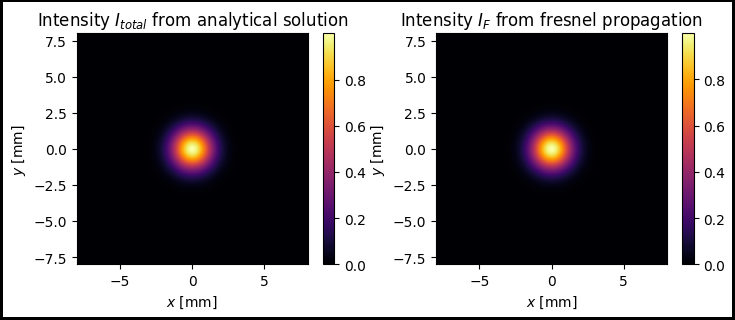

In [18]:
fig, ax = plt.subplots(
    1, 2, figsize=(8.5, 3), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(xv, yv, intensity_gb_total, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'Intensity $I_{total}$ from analytical solution')
ax[0].set_xlabel('$x$ [mm]')
ax[0].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(xv, yv, intensity_gb_end, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title(r'Intensity $I_F$ from fresnel propagation')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im2)

We numerically and analytically solve the problem of free propagation of a Gaussian beam over distance $z_{total}$ for different numbers of computational nodes:

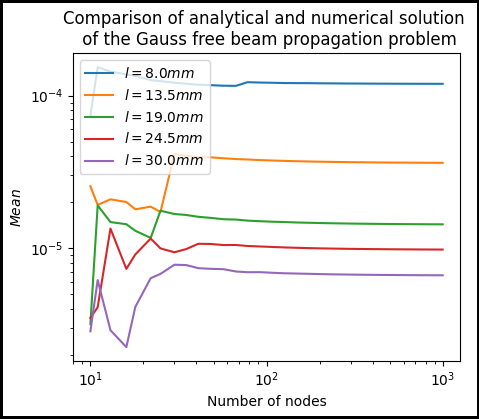

In [19]:
from tqdm import tqdm

node_array = torch.logspace(1, 3.5, 30, dtype=int)
node_array

length_array = torch.linspace(8, 30, 5)

std_list = []
energy_numeric_list = []
energy_analytic_list = []

lx = 30
ly = 30

z = 0.
z_total = 300

w0 = 2
lam = 1064*1e-6
# lam = 660* 1e-6
length = 8

w0 = 2.

fig, ax = plt.subplots(figsize=(5, 4), edgecolor='black', linewidth=3,
                       frameon=True)

ax.set_title('Comparison of analytical and numerical solution \n of the Gauss free beam propagation problem')
ax.set_xlabel('Number of nodes')
ax.set_ylabel(r'$Mean$')


for l in length_array:

    std_list = []

    for n in node_array:

        x_length = torch.linspace(-l / 2, l / 2, n)
        y_length = torch.linspace(-l / 2, l / 2, n)

        dx = l / n
        dy = l / n

        params = SimulationParameters(
            axes={
                'W': x_length,
                'H': y_length,
                'wavelength': lam
            }
        )
        xv, yv = params.meshgrid(x_axis='W', y_axis='H')

        field_gb_total = w.Wavefront.gaussian_beam(
            simulation_parameters=params,
            waist_radius=w0,
            distance=z_total
        )

        intensity_gb_total = field_gb_total.intensity

        field_gb_start = w.Wavefront.gaussian_beam(
        simulation_parameters=params,
        waist_radius=w0,
        distance=z
        )


        field_gb_end = elements.FreeSpace(
            simulation_parameters=params,
            distance=z_total - z,
            method='AS'
        ).forward(input_field=field_gb_start)

        intensity_gb_end = field_gb_end.intensity


        intensity_difference = intensity_gb_total - intensity_gb_end

        standard_deviation = torch.mean(intensity_difference.abs() )
        std_list.append(standard_deviation)

    std_list = np.array(std_list)
    ax.loglog(node_array, std_list, label=rf'$l={round(l.item(), 2)}mm$')
ax.legend()
